In [38]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.backtester.ome import OrdersManagementEngine
from qubx.trackers import PortfolioRebalancerTracker
from qubx.core.series import Quote
from qubx.data.readers import CsvStorageDataReader, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.core.utils import recognize_time

def Q(time: str, bid: float, ask: float) -> Quote:
    return Quote(recognize_time(time), bid, ask, 0, 0)

 >  [dev] installing cython rebuilding hook
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OME tests

In [3]:
r = CsvStorageDataReader('../tests/data/csv')

In [4]:
instr = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
stream = r.read('BTCUSDT_ohlcv_M1', transform=RestoreTicksFromOHLC(trades=False, spread=instr.min_tick))

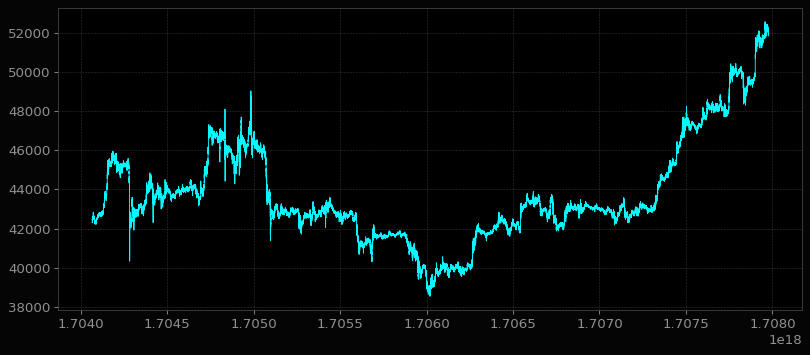

In [8]:
plt.plot(pd.Series({s.time:s.ask for s in stream}))

In [276]:
from qubx.core.basics import ITimeProvider


class Time(ITimeProvider):
    def g(self, quote: Quote) -> Quote:
        self._time = quote.time
        return quote

    def time(self) -> np.datetime64:
        return self._time

ome = OrdersManagementEngine(instr, t:=Time())
ome.update_bbo(t.g(stream[0]))

q0 = stream[0]
ome.place_order("BUY", "MARKET", 0.04, 0, "Test1")
ome.place_order("BUY", "LIMIT", 0.04, q0.bid - 100, "Test2")
ome.place_order("BUY", "LIMIT", 0.1, q0.bid - 100, "Test21")
ome.place_order("SELL", "LIMIT", 0.04, q0.ask + 100, "Test3")
ome.place_order("SELL", "LIMIT", 0.14, q0.ask + 50, "Test31")
ome.place_order("SELL", "LIMIT", 0.3, q0.ask, "Test32")
ome.place_order("BUY", "LIMIT", 0.12, q0.bid, "Test4")

2024-07-08 15:12:25.116 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.04 executed at 42314.05
2024-07-08 15:12:25.116 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100002 LIMIT BUY 0.04 42213.95
2024-07-08 15:12:25.116 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 42213.95
2024-07-08 15:12:25.116 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100004 LIMIT SELL 0.04 42414.05
2024-07-08 15:12:25.116 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100005 LIMIT SELL 0.14 42364.05
2024-07-08 15:12:25.124 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100006 LIMIT SELL 0.3 42314.05
2024-07-08 15:12:25.124 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100007 LIMIT BUY 0.12 42313.95


OmeReport(timestamp=1704067206000000000, order=Order(id='SIM-ORDER-BTCUSDT-100007', type='LIMIT', symbol='BTCUSDT', time=1704067206000000000, quantity=0.12, price=42313.95, side='BUY', status='OPEN', time_in_force='gtc', client_id='Test4', cost=0.0), exec=None)

In [294]:
ome.get_open_orders()

[]

In [ ]:
ome.cancel_order("SIM-ORDER-BTCUSDT-100007")

In [296]:
print(ome)

= = (2024-01-01T00:00:06.000000000) = =
  42314.05 : 
- - - - - - - - - - - - - - - - - - - -
  42313.95 : 
= = = = = = = = = = = = = = = = = = = =



In [256]:
for i in range(len(stream)):
    ome.update_bbo(t.g(stream[i]))
    # print(ome)

2024-07-08 15:08:30.864 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100007 LIMIT BUY 0.12 executed at 42313.95
2024-07-08 15:08:30.865 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100006 LIMIT SELL 0.3 executed at 42314.05
2024-07-08 15:08:30.866 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100005 LIMIT SELL 0.14 executed at 42364.05
2024-07-08 15:08:30.866 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100004 LIMIT SELL 0.04 executed at 42414.05
2024-07-08 15:08:30.869 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100002 LIMIT BUY 0.04 executed at 42213.95
2024-07-08 15:08:30.865 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100006 LIMIT SELL 0.3 executed at 42314.05
2024-07-08 15:08:30.866 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100005 LIMIT SELL 0.14 executed at 42364.05
2024-07-08 15:08:30.866 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100004 LIMIT SELL 0.04 executed at 42414.05
2024-07-08 15:08:30.869 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100002 LIMIT BUY 0.04 executed at 42213.95
2024-07-08 15:08:30.869 [ 🐞 ] [OM

In [257]:
print(ome)

= = (2024-02-15T06:17:54.000000000) = =
  51950.450000000004 : 
- - - - - - - - - - - - - - - - - - - -
  51950.35 : 
= = = = = = = = = = = = = = = = = = = =



In [258]:
ome.get_open_orders()

[]